In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name(), font)

Footlight MT Light C:\Windows\Fonts\FTLTLT.TTF
Trebuchet MS C:\Windows\Fonts\trebuc.ttf
Tw Cen MT Condensed C:\Windows\Fonts\TCCB____.TTF
Candara C:\Windows\Fonts\Candaraz.ttf
Rockwell Condensed C:\Windows\Fonts\ROCC____.TTF
Segoe UI C:\Windows\Fonts\segoeuii.ttf
Onyx C:\Windows\Fonts\ONYX.TTF
Mistral C:\Windows\Fonts\MISTRAL.TTF
Papyrus C:\Windows\Fonts\PAPYRUS.TTF
HyhwpEQ C:\Windows\Fonts\HYHWPEQ.TTF
Yet R C:\Windows\Fonts\HMFMOLD.TTF
Cascadia Mono C:\Windows\Fonts\CascadiaMono.ttf
Jokerman C:\Windows\Fonts\JOKERMAN.TTF
HYGungSo-Bold C:\Windows\Fonts\H2GSRB.TTF
Microsoft Sans Serif C:\Windows\Fonts\micross.ttf
Arial C:\Windows\Fonts\ariali.ttf
Bodoni MT C:\Windows\Fonts\BOD_CBI.TTF
Wide Latin C:\Windows\Fonts\LATINWD.TTF
Lucida Console C:\Windows\Fonts\lucon.ttf
Calibri C:\Windows\Fonts\calibril.ttf
MS Gothic C:\Windows\Fonts\msgothic.ttc
Book Antiqua C:\Windows\Fonts\ANTQUAI.TTF
Franklin Gothic Medium C:\Windows\Fonts\framd.ttf
Modern No. 20 C:\Windows\Fonts\MOD20.TTF
Tempus Sans IT

In [2]:
import pandas as pd
import numpy as np

# !pip install pykrx
from pykrx import stock

from tqdm import tqdm
import time

import seaborn as sns

In [3]:
df = pd.read_csv("./meta_data.csv")
df

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,120110,코오롱인더,KOSPI,화학,36550,-50,-0.14,1005822776050
1,150,두산,KOSPI,기타금융,137000,4100,3.09,2263765395000
2,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
3,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
4,4560,현대비앤지스틸,KOSPI,철강금속,20950,600,2.95,315901090450
...,...,...,...,...,...,...,...,...
141,4990,롯데지주,KOSPI,기타금융,26500,-300,-1.12,2780094780500
142,267260,HD현대일렉트릭,KOSPI,전기전자,255000,15000,6.25,9192019425000
143,1740,SK네트웍스,KOSPI,유통업,5540,-20,-0.36,1225879577080
144,5930,삼성전자,KOSPI,전기전자,78600,3100,4.11,469224908430000


In [4]:
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)

In [5]:
import numpy as np 
from statsmodels import regression
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import math
import pandas as pd 
import pandas_datareader as pdr 

In [6]:
sector_counts = df.groupby('업종명').size().reset_index(name='종목수')

print(sector_counts)

      업종명  종목수
0     건설업    6
1      기계    3
2    기타금융   20
3      보험    4
4   비금속광물    4
5    서비스업   11
6    섬유의복    1
7    운수장비   10
8   운수창고업    6
9     유통업   13
10     은행    2
11   음식료품    3
12    의약품    7
13  전기가스업    3
14   전기전자   13
15   종이목재    2
16     증권    5
17   철강금속    7
18    통신업    2
19     화학   24


In [7]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import networkx as nx

In [8]:
def create_graph_with_correlation(df, start, end):
    G = nx.Graph()
    
    # 모든 주식의 종가 데이터 가져오기
    stock_prices = {}
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        try:
            asset = fdr.DataReader(code, start, end)
            stock_prices[code] = asset['Close']
        except:
            print(f"No data for {code} ({name})")
            continue
    
    # 가장 긴 공통 기간 찾기
    min_date = max([prices.index.min() for prices in stock_prices.values() if not prices.empty])
    max_date = min([prices.index.max() for prices in stock_prices.values() if not prices.empty])
    
    # 유효한 기간이 없는 경우 처리
    if pd.isna(min_date) or pd.isna(max_date):
        raise ValueError("No common dates available in the dataset.")
    
    # 공통 기간 내의 데이터를 기준으로 필터링
    common_dates = pd.date_range(start=min_date, end=max_date)
    print(f"Common date range: {min_date} to {max_date}")

    filtered_prices = {}
    for code in stock_prices:
        filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
    # 유효한 종목 코드 필터링
    valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]

    print(f"Valid codes after filtering: {len(valid_codes)}")

    # 시가총액 상위 100개 종목 선택
    top_100_df = df[df['종목코드'].isin(valid_codes)].nlargest(100, '시가총액')
    top_100_codes = top_100_df['종목코드'].tolist()

    # 시가총액 상위 100개 종목에 대해 다시 종가 데이터를 가져오기
    stock_prices_top_100 = {code: filtered_prices[code] for code in top_100_codes}

    for idx, row in tqdm(top_100_df.iterrows(), total=top_100_df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        
        # 그래프 노드에 종목명과 업종명 추가
        G.add_node(name, sector=sector)
    
    codes = list(stock_prices_top_100.keys())
    edges = []

    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            code_i = codes[i]
            code_j = codes[j]
            
            # 두 종목의 종가 데이터 가져오기
            prices_i = stock_prices_top_100[code_i]
            prices_j = stock_prices_top_100[code_j]
            
            # 상관 관계 계산
            if len(prices_i) > 1 and len(prices_j) > 1:
                correlation = prices_i.corr(prices_j)
                if not np.isnan(correlation):
                    # 거리 계산
                    distance = np.sqrt(2 * (1 - correlation))
                    edges.append((df.loc[df['종목코드'] == code_i, '종목명'].values[0],
                                  df.loc[df['종목코드'] == code_j, '종목명'].values[0],
                                  distance))

    # 거리 기준 하위 10% 선택
    edges = sorted(edges, key=lambda x: x[2])
    num_edges_to_keep = int(len(edges) * 0.1)
    edges_to_add = edges[:num_edges_to_keep]

    # 그래프에 엣지 추가
    for edge in edges_to_add:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    # 연결된 엣지가 없는 노드 제거
    nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
    G.remove_nodes_from(nodes_to_remove)
    print(f"Nodes removed due to no edges: {len(nodes_to_remove)}")

    return G

In [9]:
# def create_graph_with_correlation(df, start, end):
#     G = nx.Graph()
    
#     # 모든 주식의 종가 데이터 가져오기
#     stock_prices = {}
#     for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         code = row["종목코드"]
#         name = row["종목명"]
#         sector = row["업종명"]
#         try:
#             asset = fdr.DataReader(code, start, end)
#             stock_prices[code] = asset['Close']
#         except:
#             print(f"No data for {code} ({name})")
#             continue
    
#     # 가장 긴 공통 기간 찾기
#     min_date = max([prices.index.min() for prices in stock_prices.values() if not prices.empty])
#     max_date = min([prices.index.max() for prices in stock_prices.values() if not prices.empty])
    
#     # 유효한 기간이 없는 경우 처리
#     if pd.isna(min_date) or pd.isna(max_date):
#         raise ValueError("No common dates available in the dataset.")
    
#     # 공통 기간 내의 데이터를 기준으로 필터링
#     common_dates = pd.date_range(start=min_date, end=max_date)
#     print(f"Common date range: {min_date} to {max_date}")

#     filtered_prices = {}
#     for code in stock_prices:
#         filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
#     # 유효한 종목 코드 필터링
#     valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]

#     print(f"Valid codes after filtering: {len(valid_codes)}")

#     # 유효한 종목 코드에 대해 다시 종가 데이터를 가져오기
#     stock_prices_valid = {code: filtered_prices[code] for code in valid_codes}

#     for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         code = row["종목코드"]
#         if code in valid_codes:
#             name = row["종목명"]
#             sector = row["업종명"]
        
#             # 그래프 노드에 종목명과 업종명 추가
#             G.add_node(name, sector=sector)
    
#     codes = list(stock_prices_valid.keys())
#     edges = []

#     for i in range(len(codes)):
#         for j in range(i + 1, len(codes)):
#             code_i = codes[i]
#             code_j = codes[j]
            
#             # 두 종목의 종가 데이터 가져오기
#             prices_i = stock_prices_valid[code_i]
#             prices_j = stock_prices_valid[code_j]
            
#             # 상관 관계 계산
#             if len(prices_i) > 1 and len(prices_j) > 1:
#                 correlation = prices_i.corr(prices_j)
#                 if not np.isnan(correlation):
#                     weight = np.sqrt(2 * (1 - correlation))
#                     edges.append((df.loc[df['종목코드'] == code_i, '종목명'].values[0],
#                                   df.loc[df['종목코드'] == code_j, '종목명'].values[0],
#                                   weight))

#     # edge weight 기준 하위 10% 선택
#     edges = sorted(edges, key=lambda x: x[2])
#     num_edges_to_keep = int(len(edges) * 0.1)
#     edges_to_add = edges[:num_edges_to_keep]

#     # 그래프에 엣지 추가
#     for edge in edges_to_add:
#         G.add_edge(edge[0], edge[1], weight=edge[2])

#     # 연결된 엣지가 없는 노드 제거
#     nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
#     G.remove_nodes_from(nodes_to_remove)
#     print(f"Nodes removed due to no edges: {len(nodes_to_remove)}")

#     return G


In [10]:
start_date = '2007-01-01'
end_date = '2008-12-31'

G = create_graph_with_correlation(df, start_date, end_date)

num_nodes = G.number_of_nodes()

print(f"Number of nodes in the graph: {num_nodes}")


  0%|          | 0/146 [00:00<?, ?it/s]

100%|██████████| 146/146 [00:58<00:00,  2.49it/s]


Common date range: 2008-07-24 00:00:00 to 2008-12-30 00:00:00
Valid codes after filtering: 86


100%|██████████| 95/95 [00:00<00:00, 9029.21it/s]


Nodes removed due to no edges: 24
Number of nodes in the graph: 62


In [11]:
print("Edge weights:")
for (u, v, weight) in G.edges(data=True):
    print(f"({u}, {v}): {weight['weight']}")

Edge weights:
(삼성전자, LG전자): 0.3185841675217442
(기아, 현대글로비스): 0.2932991660468022
(기아, 현대모비스): 0.31890641411345483
(LG화학, DL): 0.2654382770178693
(LG화학, DB하이텍): 0.26842356424382535
(LG화학, 한화손해보험): 0.272629819472823
(LG화학, 현대비앤지스틸): 0.2760440796005243
(LG화학, 삼양홀딩스): 0.279219774545366
(LG화학, 롯데케미칼): 0.2810476788119659
(LG화학, 한화솔루션): 0.2846528493051145
(LG화학, LG): 0.2921639017409162
(LG화학, SK가스): 0.30166006568217785
(LG화학, 성신양회): 0.30429775673497406
(LG화학, 세아홀딩스): 0.3190496852812837
(LG화학, HL D&I): 0.32484532083219747
(LG화학, OCI홀딩스): 0.33107420859180303
(LG화학, 팬오션): 0.3318253133389859
(신한지주, 하나금융지주): 0.19805381325293017
(신한지주, 세아홀딩스): 0.2908751515196306
(신한지주, 금호타이어): 0.2939685532057404
(신한지주, 효성): 0.30319045801216254
(신한지주, 기업은행): 0.30468506276164387
(신한지주, SK가스): 0.3302143881729668
(카카오, HL D&I): 0.1933646988386122
(카카오, 모나리자): 0.25261141547524246
(카카오, 현대비앤지스틸): 0.28046364024662873
(카카오, SK네트웍스): 0.28094052165751016
(카카오, 고려아연): 0.2883187240422552
(카카오, 하나금융지주): 0.29549157313063573
(카카오,

In [12]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

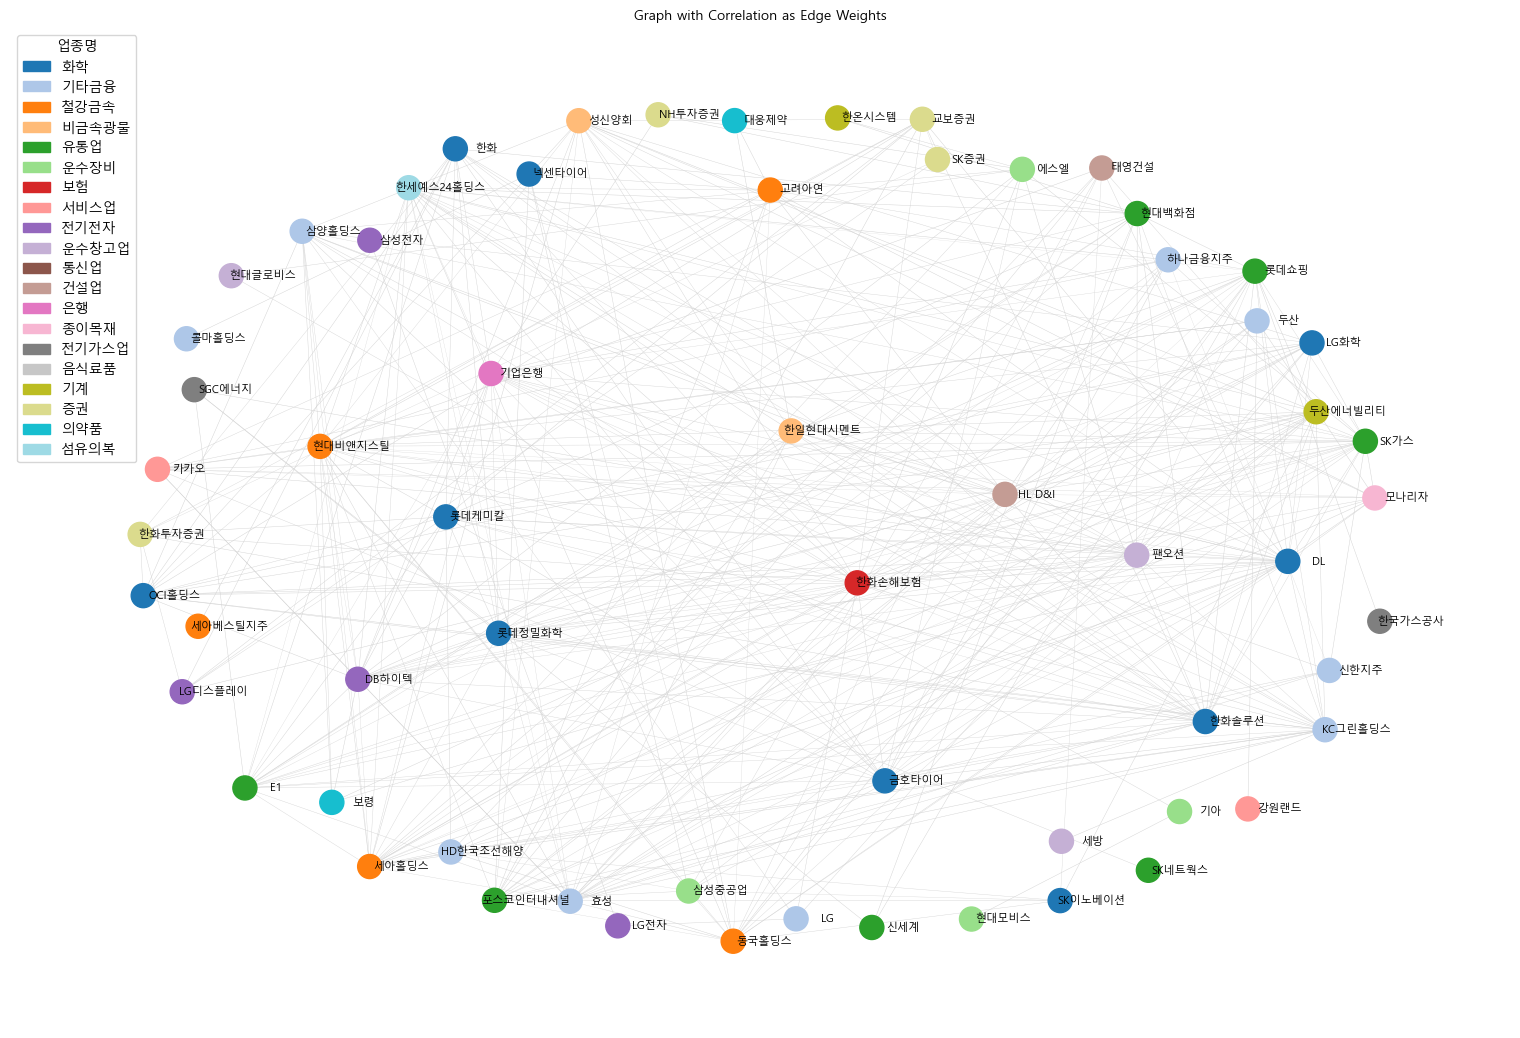

In [13]:
sectors = pd.unique(df["업종명"])
color_map = plt.get_cmap('tab20', len(sectors))
sector_color = {sector: color_map(i) for i, sector in enumerate(sectors)}

node_colors = [sector_color[G.nodes[node]['sector']] for node in G.nodes]

legend_patches = [mpatches.Patch(color=sector_color[sector], label=sector) for sector in sectors]

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=2)  # k 값을 조정하여 노드 간 거리 조정
weights = nx.get_edge_attributes(G, 'weight').values()

# 라벨 위치 조정
labels = {node: node for node in G.nodes}
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='lightgray', width=list(weights))
for p in pos:  # 라벨을 노드 옆에 배치
    pos[p][0] += 0.05
nx.draw_networkx_labels(G, pos, labels, font_family=font_prop.get_name(), font_size=8)

plt.title('Graph with Correlation as Edge Weights', fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# MST

In [14]:
mst = nx.minimum_spanning_tree(G)

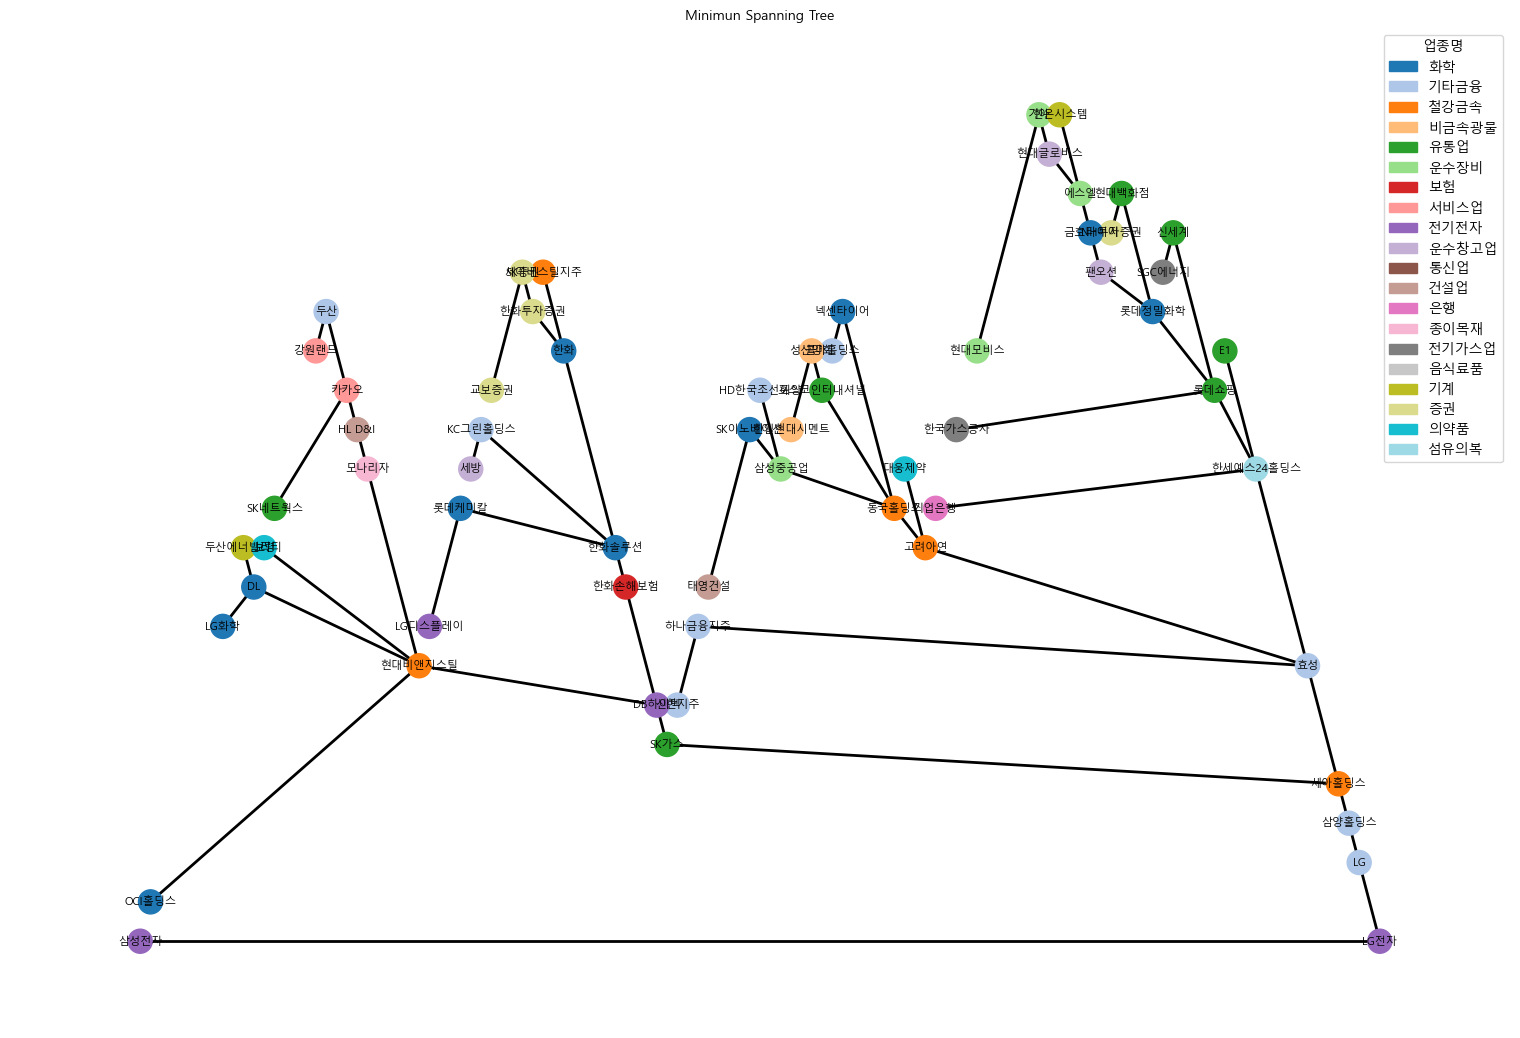

In [15]:
plt.figure(figsize=(15, 10))  
pos = nx.planar_layout(mst)  # 엣지 교차를 줄이기 위해 planar_layout 사용

nx.draw(mst, pos, with_labels=False, node_color=node_colors, edge_color='black', width=2, node_size=300)
nx.draw_networkx_labels(mst, pos, labels={node: node for node in mst.nodes()}, font_family=font_prop.get_name(), font_size=8)
plt.title("Minimun Spanning Tree", fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

In [16]:
def analyze_graph(G):
    # 평균 거리 (전체 노드 간 최단 경로의 평균)
    avg_distance = nx.average_shortest_path_length(G)
    
    # 최대 거리 (지름)
    diameter = nx.diameter(G)
    
    # Branch count
    branch_count = sum(1 for node in G.nodes if G.degree(node) > 2)
    
    # 분석 결과 반환
    return {
        "Average Distance": avg_distance,
        "Diameter": diameter,
        "Branch Count": branch_count
    }

In [17]:
components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)
mst = nx.minimum_spanning_tree(subgraph)

# Analyze the larger MST
analysis_results = analyze_graph(mst)

print(analysis_results)

{'Average Distance': 7.378106821787414, 'Diameter': 18, 'Branch Count': 15}


# Centrality Analysis

In [18]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [19]:
centrality_df = pd.DataFrame({
    '종목코드': list(G.nodes),
    '업종명': [G.nodes[node]['sector'] for node in G.nodes],
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
})

In [20]:
for centrality in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']:
    print(f"Top 5 {centrality}")
    display(centrality_df[['종목코드', '업종명', centrality]].nlargest(5, centrality))
    print("\n")

Top 5 Degree Centrality


,종목코드,업종명,Degree Centrality
39,DL,화학,0.491803
19,한화솔루션,화학,0.459016
50,현대비앤지스틸,철강금속,0.426230
46,한화손해보험,보험,0.409836
25,팬오션,운수창고업,0.393443




Top 5 Betweenness Centrality


,종목코드,업종명,Betweenness Centrality
33,에스엘,운수장비,0.112005
46,한화손해보험,보험,0.091889
50,현대비앤지스틸,철강금속,0.070065
39,DL,화학,0.069518
27,롯데쇼핑,유통업,0.064783




Top 5 Closeness Centrality


,종목코드,업종명,Closeness Centrality
39,DL,화학,0.580952
19,한화솔루션,화학,0.575472
46,한화손해보험,보험,0.559633
25,팬오션,운수창고업,0.549550
50,현대비앤지스틸,철강금속,0.544643




Top 5 Eigenvector Centrality


,종목코드,업종명,Eigenvector Centrality
19,한화솔루션,화학,0.254224
39,DL,화학,0.249637
25,팬오션,운수창고업,0.226336
46,한화손해보험,보험,0.225189
30,DB하이텍,전기전자,0.220389


# Influence Maximization

In [21]:
import random

# 독립적 연접 모델을 사용한 영향 평가 함수
def independent_cascade(G, seed_nodes, steps=1000):
    influenced_nodes = set(seed_nodes)
    new_active = set(seed_nodes)
    for _ in range(steps):
        if not new_active:
            break
        next_active = set()
        for node in new_active:
            for neighbor in G.neighbors(node):
                if neighbor not in influenced_nodes and random.random() < G[node][neighbor]['weight']:
                    next_active.add(neighbor)
        influenced_nodes.update(next_active)
        new_active = next_active
    return len(influenced_nodes)

In [22]:
# Greedy Algorithm을 사용한 시드 노드 선택
def greedy_algorithm(G, k, steps=1000):
    seed_nodes = []
    for _ in tqdm(range(k)):
        best_node = None
        max_influence = -1
        for node in tqdm(G.nodes):
            if node not in seed_nodes:
                influence = independent_cascade(G, seed_nodes + [node], steps)
                if influence > max_influence:
                    best_node = node
                    max_influence = influence
        seed_nodes.append(best_node)
    return seed_nodes

In [23]:
# 시드 노드 수 설정
k = 1

# Greedy Algorithm을 사용하여 시드 노드 선택
seed_nodes = greedy_algorithm(G, k)
print(f"Selected seed nodes: {seed_nodes}")

100%|██████████| 1/1 [00:00<00:00, 42.38it/s]

Selected seed nodes: ['한화']


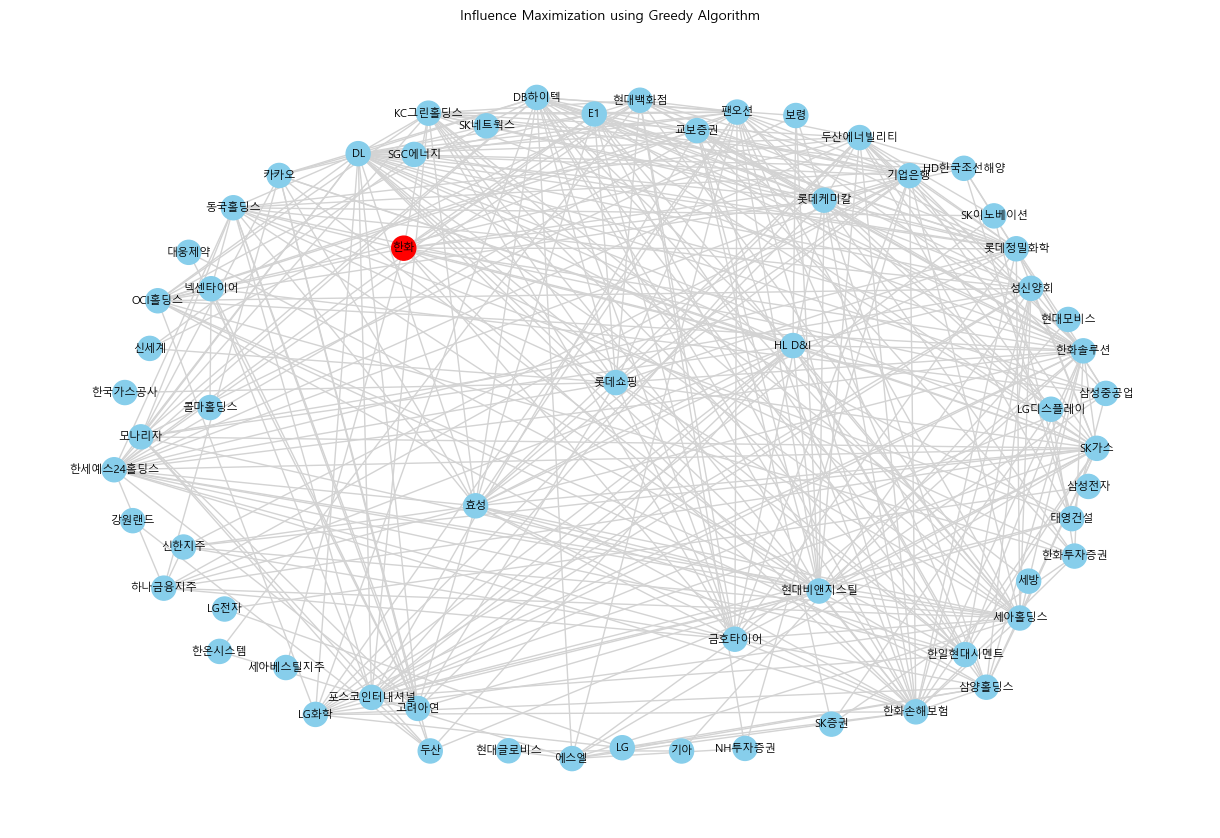

In [24]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 시각화 (선택된 시드 노드를 강조하여 표시)
pos = nx.spring_layout(G, k=2)
node_colors = ['red' if node in seed_nodes else 'skyblue' for node in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='lightgray', node_size=300, font_size=8, font_family=font_prop.get_name())  # 노드 크기 조정
plt.title("Influence Maximization using Greedy Algorithm", fontproperties=font_prop)
plt.show()

# Community Detection

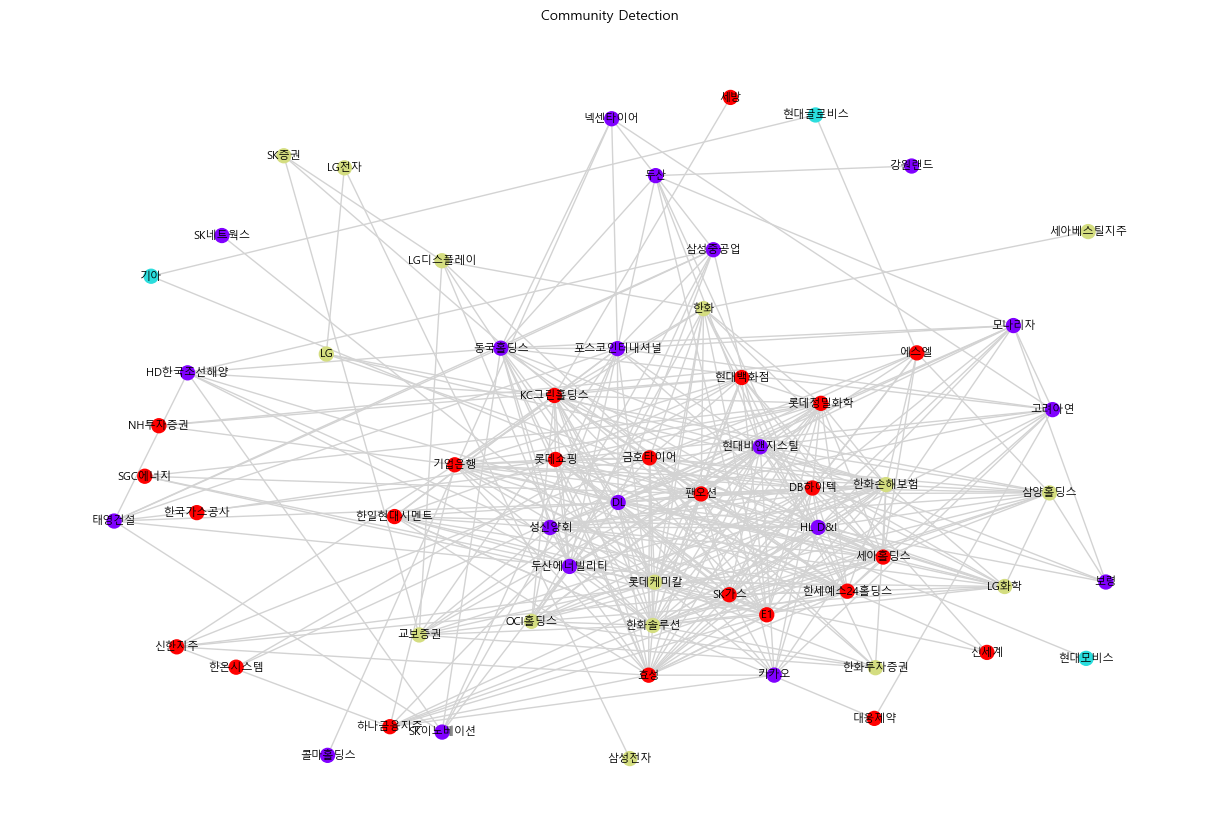

In [25]:
import community as community_louvain

partition = community_louvain.best_partition(G)

# 커뮤니티별로 노드 색상 지정
colors = [partition[node] for node in G.nodes()]

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 그래프 시각화
pos = nx.spring_layout(G, k=1)
plt.figure(figsize=(12, 8))

nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=100, edge_color='lightgray', font_size=8, font_family=font_prop.get_name())
plt.title("Community Detection", fontproperties=font_prop)

plt.show()

In [26]:
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['커뮤니티'])
community_df['종목명'] = community_df.index
community_df.reset_index(drop=True, inplace=True)

# 업종명 추가
community_df = community_df.merge(df[['종목명', '업종명']], on='종목명')

# 커뮤니티와 업종명 카운트 피벗 테이블 생성
pivot_table = community_df.pivot_table(index='커뮤니티', columns='업종명', aggfunc='size', fill_value=0)

# 커뮤니티 이름을 "community 1", "community 2" 형식으로 변경
pivot_table.index = [f"community {i+1}" for i in range(len(pivot_table))]

# 결과 출력
pivot_table

업종명,건설업,기계,기타금융,보험,비금속광물,서비스업,섬유의복,운수장비,운수창고업,유통업,은행,의약품,전기가스업,전기전자,종이목재,증권,철강금속,화학
community 1,2,1,4,0,1,2,0,1,0,2,0,1,0,0,1,0,4,3
community 2,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0
community 3,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,1,6
community 4,0,1,4,0,1,0,1,1,2,5,1,1,2,1,0,1,1,3
